In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
from pathlib import Path
import geopandas as gpd
import os, glob
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, jaccard_score
from sklearn.utils import resample
from tqdm import tqdm



In [2]:
SAFE_DIR = Path("/Users/bigwahbs/Desktop/AI4EO/Final_Report/S2A_MSIL2A_20240128T101301_N0510_R022_T32TPS_20240128T121856.SAFE")

assert SAFE_DIR.exists(), f"SAFE_DIR does not exist: {SAFE_DIR}"
assert SAFE_DIR.is_dir(), f"SAFE_DIR is not a directory: {SAFE_DIR}"

granules = list(SAFE_DIR.glob("GRANULE/*"))
print(f"Found {len(granules)} GRANULE folders")
if granules:
    print("Example GRANULE:", granules[0])

patterns = [
    "**/*SCL_20m*.jp2",
    "**/*_SCL_20m.jp2",
    "**/SCL_20m*.jp2",
    "**/*SCL*20m*.jp2",
]
candidates = []
for pat in patterns:
    candidates.extend(SAFE_DIR.glob(pat))
candidates = sorted(set(candidates))

print(f"Found {len(candidates)} SCL candidates")
for c in candidates[:5]:
    print("  ", c)

if not candidates:

    print("\nNo SCL found. Check these points:")
    print(" - Is this an L2A product? (name should contain 'MSIL2A')")
    print(" - Is this the correct SAFE folder?")
    print(" - Try opening GRANULE/.../IMG_DATA/R20m/ and look for SCL JP2 manually.")
else:
    scl_path = candidates[0]
    print("Using SCL:", scl_path)


Found 1 GRANULE folders
Example GRANULE: /Users/bigwahbs/Desktop/AI4EO/Final_Report/S2A_MSIL2A_20240128T101301_N0510_R022_T32TPS_20240128T121856.SAFE/GRANULE/L2A_T32TPS_A044921_20240128T101353
Found 1 SCL candidates
   /Users/bigwahbs/Desktop/AI4EO/Final_Report/S2A_MSIL2A_20240128T101301_N0510_R022_T32TPS_20240128T121856.SAFE/GRANULE/L2A_T32TPS_A044921_20240128T101353/IMG_DATA/R20m/T32TPS_20240128T101301_SCL_20m.jp2
Using SCL: /Users/bigwahbs/Desktop/AI4EO/Final_Report/S2A_MSIL2A_20240128T101301_N0510_R022_T32TPS_20240128T121856.SAFE/GRANULE/L2A_T32TPS_A044921_20240128T101353/IMG_DATA/R20m/T32TPS_20240128T101301_SCL_20m.jp2


In [3]:
scl_path = SAFE_DIR / "GRANULE" / "L2A_T32TPS_A044921_20240128T101353" / "IMG_DATA" / "R20m" / "T32TPS_20240128T101301_SCL_20m.jp2"

with rasterio.open(scl_path) as src:
    scl = src.read(1)
    scl_profile = src.profile

SNOW = 11
CLOUDY = {3, 8, 9, 10}  
valid = (~np.isin(scl, list(CLOUDY))) & (scl != 0)
y = (scl == SNOW).astype(np.uint8)   # label 1 snow, 0 not snow

print("Label shape:", y.shape, "| snow pixels:", y.sum(), "| valid pixels:", valid.sum())


Label shape: (5490, 5490) | snow pixels: 11024473 | valid pixels: 30112432


In [4]:
#Check if we have 10m

r10 = list(SAFE_DIR.glob("**/IMG_DATA/R10m/*"))
r20 = list(SAFE_DIR.glob("**/IMG_DATA/R20m/*"))

print("R10m files:", len(r10))
for p in r10[:10]:
    print("  R10m:", p.name)

print("\nR20m files:", len(r20))
for p in r20[:15]:
    print("  R20m:", p.name)


R10m files: 1
  R10m: T32TPS_20240128T101301_AOT_10m.jp2

R20m files: 14
  R20m: T32TPS_20240128T101301_B12_20m.jp2
  R20m: T32TPS_20240128T101301_B02_20m.jp2
  R20m: T32TPS_20240128T101301_B03_20m.jp2
  R20m: T32TPS_20240128T101301_B11_20m.jp2
  R20m: T32TPS_20240128T101301_B01_20m.jp2
  R20m: T32TPS_20240128T101301_SCL_20m.jp2
  R20m: T32TPS_20240128T101301_B05_20m.jp2
  R20m: T32TPS_20240128T101301_AOT_20m.jp2
  R20m: T32TPS_20240128T101301_B04_20m.jp2
  R20m: T32TPS_20240128T101301_WVP_20m.jp2
  R20m: T32TPS_20240128T101301_TCI_20m.jp2
  R20m: T32TPS_20240128T101301_B06_20m.jp2
  R20m: T32TPS_20240128T101301_B8A_20m.jp2
  R20m: T32TPS_20240128T101301_B07_20m.jp2


In [5]:
def find_one(patterns):
    for pat in patterns:
        hits = sorted(glob.glob(os.path.join(SAFE_DIR.as_posix(), "**", pat), recursive=True))
        if hits:
            return hits[0]
    return None

def read_match_grid(band_path, ref_path, resampling=Resampling.bilinear):
    with rasterio.open(band_path) as src_in, rasterio.open(ref_path) as ref:
        out = np.empty((ref.height, ref.width), dtype=np.float32)
        reproject(source=rasterio.band(src_in, 1),
                  destination=out,
                  src_transform=src_in.transform, src_crs=src_in.crs,
                  dst_transform=ref.transform, dst_crs=ref.crs,
                  resampling=resampling)
    return out

# this tries 10m first if not found it uses 20m (after the previous check if we found tha we do not have 10m in our build)
b02_path = find_one(["*B02_10m*.jp2", "*B02_20m*.jp2"])
b03_path = find_one(["*B03_10m*.jp2", "*B03_20m*.jp2"])
b04_path = find_one(["*B04_10m*.jp2", "*B04_20m*.jp2"])
b8a_path = find_one(["*B8A_20m*.jp2"])
b11_path = find_one(["*B11_20m*.jp2"])
b12_path = find_one(["*B12_20m*.jp2"])

for name, p in [("B02", b02_path), ("B03", b03_path), ("B04", b04_path),
                ("B8A", b8a_path), ("B11", b11_path), ("B12", b12_path)]:
    assert p is not None, f"Could not find {name} file in SAFE (searched common patterns)."

# Read and reproject all to the SCL 20m grid
b02 = read_match_grid(b02_path, scl_path)
b03 = read_match_grid(b03_path, scl_path)
b04 = read_match_grid(b04_path, scl_path)
b8a = read_match_grid(b8a_path, scl_path)
b11 = read_match_grid(b11_path, scl_path)
b12 = read_match_grid(b12_path, scl_path)


ndvi = (b8a - b04) / (b8a + b04 + 1e-6)
ndsi = (b03 - b11) / (b03 + b11 + 1e-6)

Xstack = np.stack([b02, b03, b04, b8a, b11, b12, ndvi, ndsi], axis=-1)
finite = np.isfinite(Xstack).all(-1)
keep = finite & valid

print("Loaded feature stack:", Xstack.shape, "| usable pixels:", keep.sum())


Loaded feature stack: (5490, 5490, 8) | usable pixels: 30112432


In [6]:
h, w = y.shape
left = np.s_[:, :w//2]
right = np.s_[:, w//2:]

def train_eval(train_region, test_region, max_samples=150_000):
    Xt = Xstack[train_region][keep[train_region]]
    yt = y[train_region][keep[train_region]]
    Xv = Xstack[test_region][keep[test_region]]
    yv = y[test_region][keep[test_region]]

    # if too slow reduce the max samples
    if Xt.shape[0] > max_samples:
        idx = resample(np.arange(Xt.shape[0]), n_samples=max_samples, random_state=0, replace=False)
        Xt, yt = Xt[idx], yt[idx]

    clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)
    clf.fit(Xt, yt)
    yp = clf.predict(Xv)

    report = classification_report(yv, yp, target_names=["No snow", "Snow"], digits=3)
    iou = jaccard_score(yv, yp)  # iou of the Snow class

    return clf, yp, report, iou

print("Train left → Test right")
clf_AB, yp_AB, rep_AB, iou_AB = train_eval(left, right)
print(rep_AB)
print("IoU (Snow):", round(iou_AB, 3))

print("\nTrain right → Test left")
clf_BA, yp_BA, rep_BA, iou_BA = train_eval(right, left)
print(rep_BA)
print("IoU (Snow):", round(iou_BA, 3))


Train left → Test right
              precision    recall  f1-score   support

     No snow      0.950     0.963     0.957  10980546
        Snow      0.898     0.863     0.880   4084524

    accuracy                          0.936  15065070
   macro avg      0.924     0.913     0.918  15065070
weighted avg      0.936     0.936     0.936  15065070

IoU (Snow): 0.786

Train right → Test left
              precision    recall  f1-score   support

     No snow      0.931     0.952     0.941   8107413
        Snow      0.943     0.917     0.930   6939949

    accuracy                          0.936  15047362
   macro avg      0.937     0.935     0.936  15047362
weighted avg      0.936     0.936     0.936  15047362

IoU (Snow): 0.869


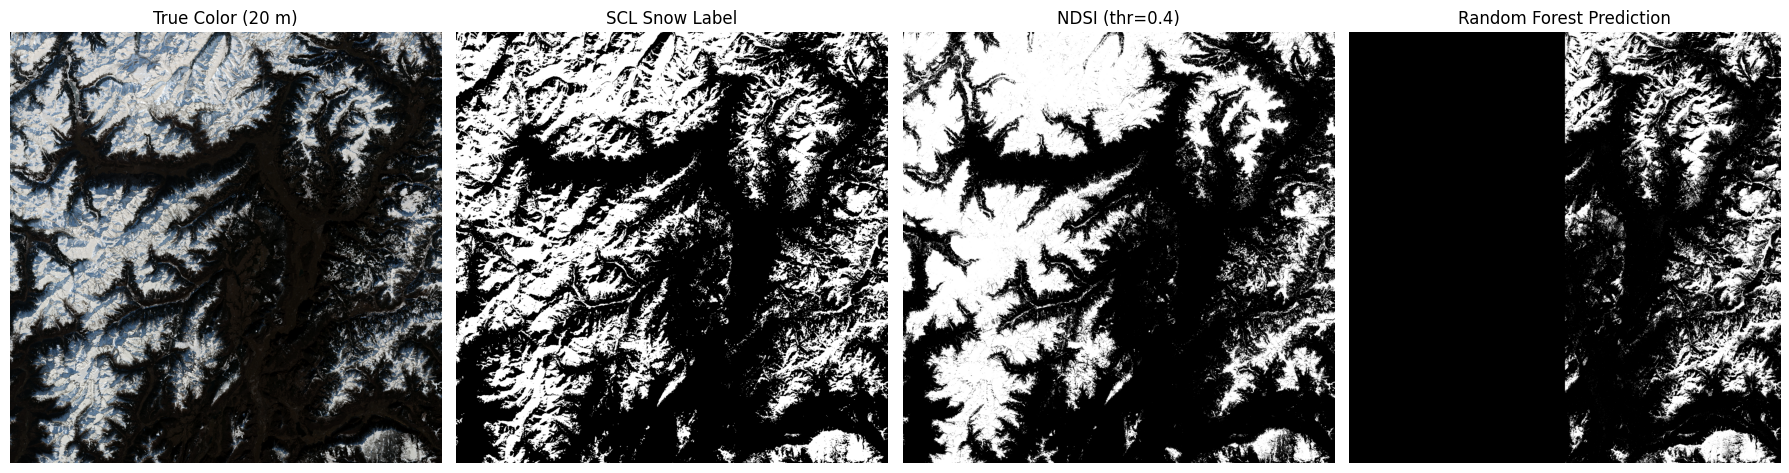

In [7]:
# simple clip for display
rgb = np.stack([b04, b03, b02], axis=-1)
rgb_disp = rgb.copy()
rgb_disp = (rgb_disp - np.nanpercentile(rgb_disp, 2)) / (np.nanpercentile(rgb_disp, 98) - np.nanpercentile(rgb_disp, 2) + 1e-6)
rgb_disp = np.clip(rgb_disp, 0, 1)

# SCL snow
scl_snow = (scl == SNOW).astype(np.uint8)

# NDSI threshold mask previous
ndsi_mask = (ndsi > 0.4).astype(np.uint8)

# RF prediction map AB split
pred_map = np.zeros_like(y, dtype=np.uint8)
pred_map[right][keep[right]] = yp_AB  

fig, axs = plt.subplots(1, 4, figsize=(18, 5))
axs[0].imshow(rgb_disp)
axs[0].set_title("True Color (20 m)"); axs[0].axis("off")

axs[1].imshow(scl_snow, cmap="gray")
axs[1].set_title("SCL Snow Label"); axs[1].axis("off")

axs[2].imshow(ndsi_mask, cmap="gray")
axs[2].set_title("NDSI (thr=0.4)"); axs[2].axis("off")

axs[3].imshow(pred_map, cmap="gray")
axs[3].set_title("Random Forest Prediction"); axs[3].axis("off")

plt.tight_layout(); plt.show()


In [11]:
outdir = Path("./outputs")
outdir.mkdir(exist_ok=True)

with open(outdir / "metrics_geocv.txt", "w") as f:
    f.write("Train left → Test right\n")
    f.write(rep_AB + "\n")
    f.write(f"IoU (Snow): {iou_AB:.3f}\n\n")
    f.write("Train right → Test left\n")
    f.write(rep_BA + "\n")
    f.write(f"IoU (Snow): {iou_BA:.3f}\n")

print("Saved:", outdir / "metrics_geocv.txt")

fig.savefig(outdir / "figure_comparison.png", dpi=200, bbox_inches="tight")
print("Saved:", outdir / "figure_comparison.png")



Saved: outputs/metrics_geocv.txt
Saved: outputs/figure_comparison.png


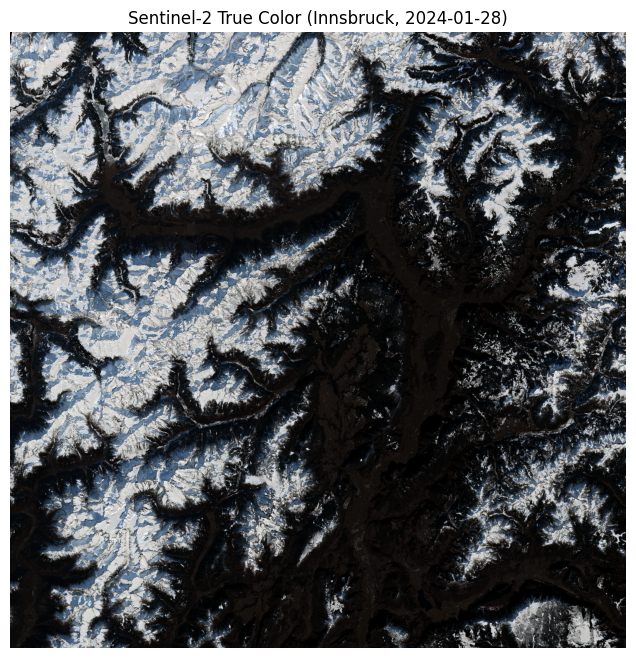

In [ ]:
#og image

def stretch(img, lower=2, upper=98):
    """Simple contrast stretching to make RGB look natural"""
    p2, p98 = np.percentile(img, (lower, upper))
    return np.clip((img - p2) / (p98 - p2), 0, 1)


rgb = np.dstack([
    stretch(b04),
    stretch(b03), 
    stretch(b02)   
])

plt.figure(figsize=(8,8))
plt.imshow(rgb)
plt.title("Sentinel-2 True Color (Innsbruck, 2024-01-28)")
plt.axis("off")
plt.savefig("sentinel_rgb.png", dpi=300, bbox_inches="tight")
plt.show()
